# Reconnaissance d'empreinte digitale
#### Chargement des données et division en 3 (entrainement, validation et test)

In [ ]:
# Reconnaissance d'empreinte digitale
#### Chargement des données et division en 3 (entrainement, validation et test)
import os
import shutil
from glob import glob
from sklearn.model_selection import train_test_split

# Fonction pour créer les répertoires de destination si nécessaire
def create_dir_if_not_exists(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Dossier contenant les dossiers d'empreintes digitales
base_folder = '/home/rosalie/Bureau/M1_SDIA/S2/Projet/biometrie/data'

# Dossiers de sortie
train_dir = '/home/rosalie/Bureau/M1_SDIA/S2/Projet/biometrie/data_split/train'
val_dir = '/home/rosalie/Bureau/M1_SDIA/S2/Projet/biometrie/data_split/val'
test_dir = '/home/rosalie/Bureau/M1_SDIA/S2/Projet/biometrie/data_split/test'

create_dir_if_not_exists(train_dir)
create_dir_if_not_exists(val_dir)
create_dir_if_not_exists(test_dir)

# Parcourir chaque sous-dossier dans le dossier de base
for person_folder in os.listdir(base_folder):
    person_folder_path = os.path.join(base_folder, person_folder)
    if os.path.isdir(person_folder_path):
        # Lister toutes les images d'empreintes digitales dans le sous-dossier
        image_paths = glob(os.path.join(person_folder_path, '*.png'))  # Modifier selon l'extension de vos images

        # Diviser les données en train, val et test
        train_and_val, test = train_test_split(image_paths, test_size=0.2, random_state=42)
        train, val = train_test_split(train_and_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

        # Créer des sous-dossiers pour chaque personne dans les dossiers de sortie
        person_train_dir = os.path.join(train_dir, person_folder)
        person_val_dir = os.path.join(val_dir, person_folder)
        person_test_dir = os.path.join(test_dir, person_folder)

        create_dir_if_not_exists(person_train_dir)
        create_dir_if_not_exists(person_val_dir)
        create_dir_if_not_exists(person_test_dir)

        # Copier les fichiers dans les dossiers de sortie respectifs
        for image_path in train:
            shutil.copy(image_path, os.path.join(person_train_dir, os.path.basename(image_path)))
        for image_path in val:
            shutil.copy(image_path, os.path.join(person_val_dir, os.path.basename(image_path)))
        for image_path in test:
            shutil.copy(image_path, os.path.join(person_test_dir, os.path.basename(image_path)))

print("Données séparées avec succès en ensembles d'entraînement, de validation et de test.")


## Prétaitement des données 

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import protobuf

# Vérifier les versions pour assurer la compatibilité
print("TensorFlow version:", tf.__version__)
print("Protobuf version:", protobuf.__version__)

# Paramètres
img_height, img_width = 128, 128  # Taille des images après redimensionnement
batch_size = 32

# Dossiers contenant les images
train_data_dir = '/home/rosalie/Bureau/M1_SDIA/S2/Projet/biometrie/data_split/train'
val_data_dir = '/home/rosalie/Bureau/M1_SDIA/S2/Projet/biometrie/data_split/val'

# Préparation des générateurs de données
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)


## Utilisons une méthode d'apprentissage par transfert

Elle consistera à faire usage d'un modèle pré-entrainé comme modèle de base qui sera juste modifié par la suite afin de l'entrainé sur nos données.

Nous allons faire usage du modèle VGG16 comme modèle de base 

### Chargement du modèle et définition de ce dernier 

In [ ]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])


### Compilation du modèle 

In [ ]:
# Compiler le modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               4194816   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         


                                                                 
 dense_3 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 18,913,608
Trainable params: 4,198,920
Non-trainable params: 14,714,688
_________________________________________________________________


### Entrainement du modèle sur nos données prétraitées 

In [ ]:
import pickle

# Entraînement du modèle
epochs = 100

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=[early_stopping, checkpoint]
)

# Sauvegarder le modèle 
model.save('biometrie.h5')

# Sauvegarder l'historique de l'entraînement
with open('train_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# Charger l'historique de l'entraînement
with open('train_history.pkl', 'rb') as f:
    history = pickle.load(f)

Epoch 1/100
7/7 [==============================] - 34s 5s/step - loss: 2.7541 - accuracy: 0.3304 - val_loss: 1.0727 - val_accuracy: 0.6875
Epoch 2/100
7/7 [==============================] - 32s 5s/step - loss: 1.0431 - accuracy: 0.6600 - val_loss: 0.7499 - val_accuracy: 0.7812
Epoch 3/100
7/7 [==============================] - 36s 5s/step - loss: 0.6898 - accuracy: 0.8050 - val_loss: 0.5980 - val_accuracy: 0.8438
Epoch 4/100
7/7 [==============================] - 31s 5s/step - loss: 0.3174 - accuracy: 0.9000 - val_loss: 0.3755 - val_accuracy: 0.8906
Epoch 5/100
7/7 [==============================] - 33s 5s/step - loss: 0.3136 - accuracy: 0.9050 - val_loss: 0.3468 - val_accuracy: 0.8906
Epoch 6/100
7/7 [==============================] - 35s 5s/step - loss: 0.2308 - accuracy: 0.9300 - val_loss: 0.3528 - val_accuracy: 0.8594
Epoch 7/100
7/7 [==============================] - 33s 5s/step - loss: 0.1239 - accuracy: 0.9750 - val_loss: 0.2936 - val_accuracy: 0.8906
Epoch 8/100
7/7 [==========

### Afficher l'évolution des erreurs et des précisions durant l'entrainement sur un graphique fait avec matplotlib

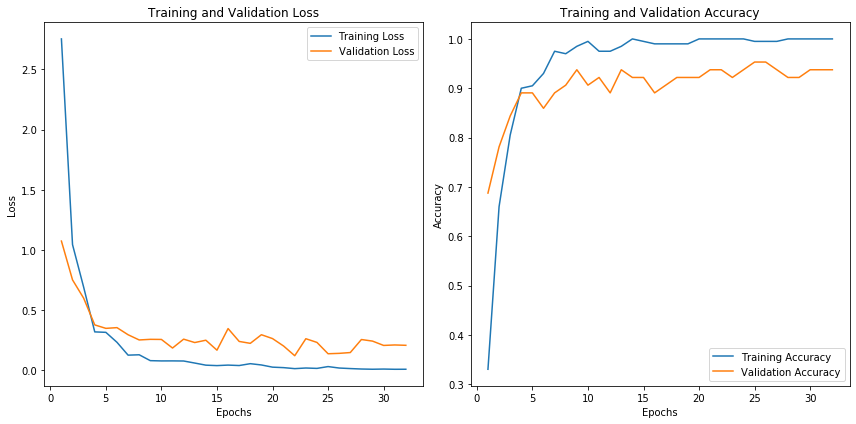

In [ ]:
import matplotlib.pyplot as plt 

# Extraire les données de l'historique
loss = history['loss']
val_loss = history['val_loss']
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']
epochs_range = range(1, len(loss) + 1)

# Visualiser l'évolution de la perte (loss)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Visualiser l'évolution de la précision (accuracy)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Evaluation du modèle sur les données de test

Nous allons générer les prédictions faites par notre modèle sur les données de test afin de les comparer avec les réelles classes des empreintes des personnes 

In [ ]:
# Faire des prédictions
predictions = model.predict(test_generator, steps=test_generator.samples // batch_size + 1)

# Obtenir les indices des classes prédites
predicted_classes = np.argmax(predictions, axis=1)

3/3 [==============================] - 10s 3s/step


In [ ]:
predicted_classes

array([0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7])

### Mapper les prédictions aux noms des sous dossiers 

In [ ]:
# Obtenir le nom des classes (sous-dossiers) dans l'ordre de l'indexation
class_indices = test_generator.class_indices
index_to_class = {v: k for k, v in class_indices.items()}

# Mapper les indices prédites aux noms des classes
predicted_class_names = [index_to_class[idx] for idx in predicted_classes]


In [ ]:
predicted_class_names

### Comparer les prédictions aux noms réels 

In [ ]:
# Obtenir les noms réels des classes (noms des sous-dossiers)
true_classes = test_generator.classes
true_class_names = [index_to_class[idx] for idx in true_classes]

# Comparer les prédictions aux noms réels
correct_predictions = np.sum(np.array(predicted_class_names) == np.array(true_class_names))
total_predictions = len(predicted_class_names)
accuracy = correct_predictions / total_predictions

print(f'Accuracy: {accuracy * 100:.2f}%')


Accuracy: 95.00%


## tests

In [ ]:
from keras.models import load_model

model = load_model("biometrie.h5")

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Prétraitement 
def preprocess_image(image_path):
    img_height, img_width = 128, 128  # Taille des images après redimensionnement
    img = image.load_img(image_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalise les valeurs des pixels
    return img_array

# Vérification avec notre modèle 
def verify_fingerprint(image_path, current_username, model, threshold=0.8):
    preprocessed_image = preprocess_image(image_path)
    predictions = model.predict(preprocessed_image)
    predicted_probabilities = np.max(predictions, axis=1)
    predicted_class = np.argmax(predictions, axis=1)[0]  # Récupère la classe prédite

    # Créez votre dictionnaire de mappage ici ou chargez-le depuis une configuration
    class_to_username = {0: 'Corine', 1: 'Fofie', 2: 'Harold', 3: 'Marah', 4: 'Ngessi', 5: 'Nyemb'}
       
    # Obtenir le nom d'utilisateur prédit
    predicted_username = class_to_username.get(predicted_class)

    # Convertir les noms en majuscules pour éviter la sensibilité à la casse
    predicted_username_upper = predicted_username.capitalize() if predicted_username else None
    current_username_upper = current_username.capitalize()

    # Vérifiez si le nom d'utilisateur prédit correspond au nom d'utilisateur actuel avec une probabilité suffisante
    if predicted_username_upper == current_username_upper and predicted_probabilities >= threshold:
        return True, predicted_probabilities
    else:
        return False, predicted_probabilities



In [ ]:
verify_fingerprint("data_split/test/Harold/h3.png", model=model, current_username="Harold")[0]

1/1 [==============================] - 1s 556ms/step


True

### Une autre approche pour faire l'évaluation du modèle 

In [ ]:
# Obtenir les noms de classes réelles
real_classes = test_generator.classes

# Obtenir les noms des classes
class_labels = list(test_generator.class_indices.keys())

# Créer un dictionnaire pour mapper les indices aux noms des classes
index_to_class = {v: k for k, v in test_generator.class_indices.items()}


In [ ]:
index_to_class

{0: 'Corine',
 1: 'Fofie',
 2: 'Harold',
 3: 'Kum',
 4: 'Lissouck',
 5: 'Marah',
 6: 'Ngessi',
 7: 'Nyemb'}

### Comparer les classes prédites avec les classes réelles et stockons les résultats dans un fichier csv

In [ ]:
import pandas as pd

# Créer une liste pour stocker les résultats
results = []

# Parcourir toutes les images dans le générateur de test
for i, (pred, real) in enumerate(zip(predicted_classes, real_classes)):
    predicted_name = index_to_class[pred]
    real_name = index_to_class[real]
    results.append((i, predicted_name, real_name))

# Créer un DataFrame à partir des résultats
results_df = pd.DataFrame(results, columns=['Image Index', 'Predicted Name', 'Real Name'])

# Afficher les premiers résultats
print(results_df.head(10))

# Sauvegarder les résultats dans un fichier CSV pour une analyse plus approfondie
results_df.to_csv('test_results.csv', index=False)


   Image Index Predicted Name Real Name
0            0         Corine    Corine
1            1         Corine    Corine
2            2         Corine    Corine
3            3         Corine    Corine
4            4         Corine    Corine
5            5         Corine    Corine
6            6         Corine    Corine
7            7          Nyemb    Corine
8            8         Corine    Corine
9            9         Corine    Corine


### Visualisation des erreurs 

Visualisons les cas ou le modèle a fait des erreurs, Nous affichons toutes les sorties sur lesquelles notre modèle se trompe

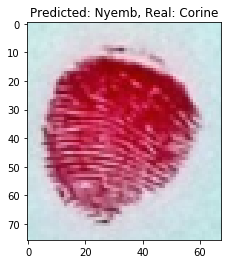

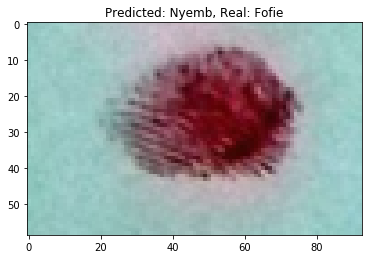

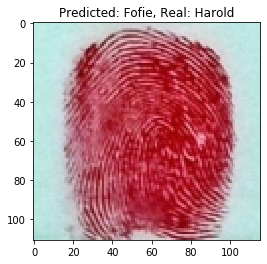

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Obtenir les chemins des fichiers d'images de test
test_filenames = test_generator.filenames

# Parcourir et afficher quelques exemples où le modèle s'est trompé
for i, (pred, real) in enumerate(zip(predicted_classes, real_classes)):
    if pred != real:
        predicted_name = index_to_class[pred]
        real_name = index_to_class[real]
        img_path = test_filenames[i]

        # Charger l'image
        img = plt.imread(test_generator.filepaths[i])

        # Afficher l'image avec les étiquettes prédite et réelle
        plt.imshow(img)
        plt.title(f'Predicted: {predicted_name}, Real: {real_name}')
        plt.show()

        # Afficher uniquement quelques exemples d'erreurs
        #if i >= 5:
         #   break
